# Assignment 2: Sentence Classification and Token Classification 

## Programming Assignment (Total: 100 points)

For this assignment we will be implementing a naive bayes baseline classifier. Additionally, we will be using pytorch to implement a binary logistic regression classifier. Our task is sentiment classification for hotel reviews. The input to your model will be a text review, and the output label is a 1 or 0 marking it as positive or negative.

We have provided a util.py file for loading the data, and some of the basic modeling. Your task is to fill in the functions below in order to train as accurate a classifier as possible!

We suggest browsing the util.py script first. Additionally, make sure to install dependencies from the provided requirements.txt file in a similar fashion to the pytorch tutorial. With your environment activated int he terminal, run:
```
mamba env create -n cs5293-2 python=3.10
pip install -r requirements.txt
##Your VSCode may complain sometime you need to install ipykernel using the following commands. If not, then  just ignore this. 
#mamba install -n cs5293-2 ipykernel  --force-reinstall 
```

In [648]:
from typing import List
import spacy
import torch
import random
import os
import sys
sys.path.append("../src")
print(sys.path)

['/Users/sairishith/Desktop/assignment_2/notebooks', '/Users/sairishith/miniforge3/envs/cs5293-2/lib/python310.zip', '/Users/sairishith/miniforge3/envs/cs5293-2/lib/python3.10', '/Users/sairishith/miniforge3/envs/cs5293-2/lib/python3.10/lib-dynload', '', '/Users/sairishith/miniforge3/envs/cs5293-2/lib/python3.10/site-packages', '../src', '../src', '../src', '/var/folders/s1/jq1jylpx1zq5fcqqyfyt0jg00000gn/T/tmpuuo3b61u', '../src', '../src', '../src', '../src', '../src', '../src', '../src', '../src', '../src', '../src', '../src', '../src', '../src']


## Section 1: Dataset Exploration (Total: 10 Points)

The training data for this task consists of a collection of short hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [649]:
from util import load_train_data
pos_datapath = "../data/hotelPosT-train.txt"
neg_datapath = "../data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)

### Lets look at what is in the data

In [650]:
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))

--- Positive Example ---
My husband and I recently spent 3 nights at The Flamingo Las Vegas. We very much enjoyed our experience there! The Flamingo is located at the center of the Strip and we were in short walking distance to tons of restaurants and other hotels. Our room had floor to ceiling windows with an AMAZING view of the strip and the Bellagio fountains. The room was updated with a very large flat screen TV in the living room and even a small TV in the bathroom mirror! Check-in was very quick and easy and all of the staff were extremely friendly. The hotel wasn't stuffy or uppity like other hotels we have been to on the Vegas Strip. The grounds were superbly kept and extremely peaceful at night.   We ate at the various places in the hotel several times and were pleased with each experience. Margaritaville had a great atmosphere and great service. We ordered room service for breakfast and the french toast was amazing!   My husband and I plan to return to Vegas this year and wil

### Test Data ( WAIT TILL DEADLINE)

This is the test dataset that you will need to use to report the results on. This set is the unseen dataset meaning, you are not in anyway supoose to look what is in this dataset. We will release this dataset on the last day of the assignment's deadline.

In [651]:
### RUN THIS ONLY ON DEADLINE ###
# Load the test data

from util import load_inference_data
from typing import List, Tuple, Any

def load_test_data(filepath: str) -> Tuple[List[Any], List[Any]]:
    """Load the test data, producing a List of texts, labels
    Args:
        filepath (str): Path to the training file

    Returns:
        Tuple[List[Any], List[Any]]: The texts and labels
    """
    lab_map = {'POS': 1, 'NEG': 0}
    texts = []
    labels = []
    with open(filepath, "r") as file:
        for line in file:
            idx, text, label = line.rstrip().split("\t")
            texts.append(text)
            labels.append(lab_map[label])

    return texts, labels

test_datapath = "../data/HW2-testset.txt"
test_texts, test_labels = load_test_data(test_datapath)

### Task 1.1: Print the number of "positive" and "negative" samples (5 Points)

It is important to know the distribution of the training examples. More often than not, you will have to work with datasets that are not "balanced" with respect to the labels of the samples. For this task, print out the number of examples that have label = 1 and label = 0, respectively, in std:out or plot a pie chart.

In [652]:
import matplotlib.pyplot as plt
# What is matplotlib? Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

The Number of positive samples 95
The Number of negative samples 94


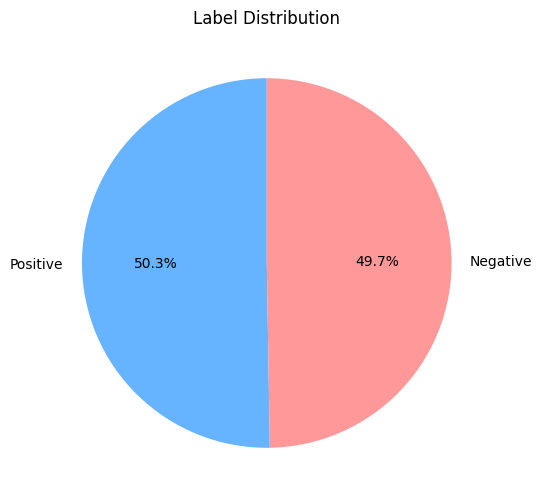

In [653]:
### ENTER CODE HERE ###

# Note since we have them in two seperate files, 
# this can also be done with bash commands
def label_distribution(labels):
    """
    TODO: Replace the line `raise NotImplementedError` with your code
    to print the labels distribution.
    """
    pos_count = sum(1 for label in labels if label == 1)
    neg_count = sum(1 for label in labels if label == 0)
    print("The Number of positive samples",pos_count)
    print("The Number of negative samples",neg_count)
    counts = [pos_count, neg_count]
    labels_pie = ["Positive", "Negative"]
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels_pie, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
    plt.title("Label Distribution")
    plt.show()

    
label_distribution(all_labels)

### Task 1.2: Split Training and Development Sets (5 Points)

For the purpose of coming with the best parameters for the model you will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

Train Label Distribution:
The Number of positive samples 76
The Number of negative samples 75


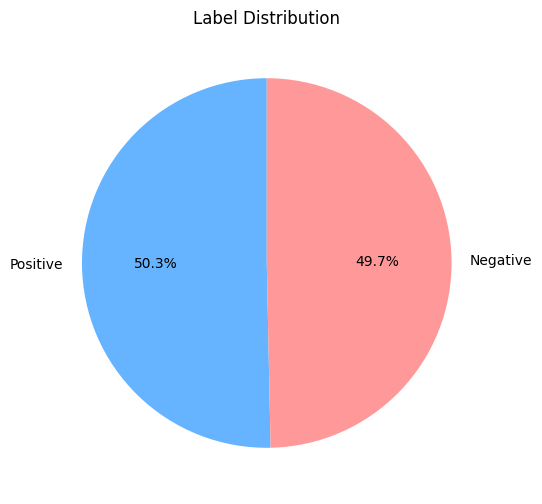

Dev Label Distribution:
The Number of positive samples 19
The Number of negative samples 19


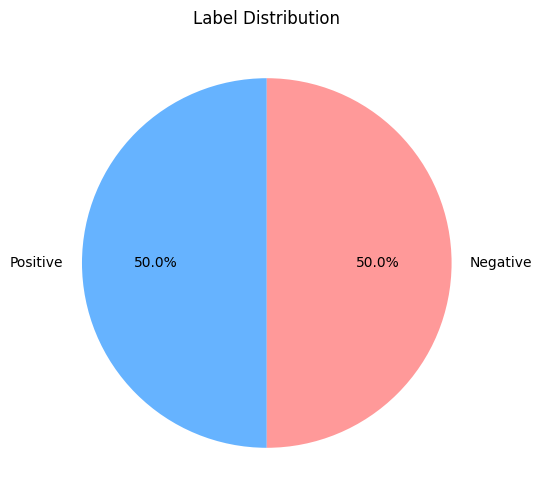

In [654]:
### ENTER CODE HERE ###

def split_dataset(texts, labels):
    """
    Split the dataset randomly into 80% training and 20% development set
    Make sure the splits have the same label distribution
    """
    train_texts = []
    train_labels = []
    dev_texts = []
    dev_labels = []
    # Combine and separate classes
    combined = list(zip(texts, labels))
    positives = [item for item in combined if item[1] == 1]
    negatives = [item for item in combined if item[1] == 0]
    # Process positive class
    random.shuffle(positives)
    pos_split = max(1, int(len(positives) * 0.8))
    for text, label in positives[:pos_split]:
        train_texts.append(text)
        train_labels.append(label)
    for text, label in positives[pos_split:]:
        dev_texts.append(text)
        dev_labels.append(label)
    
    # Process negative class
    random.shuffle(negatives)
    neg_split = max(1, int(len(negatives) * 0.8))
    for text, label in negatives[:neg_split]:
        train_texts.append(text)
        train_labels.append(label)
    for text, label in negatives[neg_split:]:
        dev_texts.append(text)
        dev_labels.append(label)
        
    # Final shuffle of combined sets
    train_combined = list(zip(train_texts, train_labels))
    random.shuffle(train_combined)
    train_texts[:], train_labels[:] = zip(*train_combined) if train_combined else ([], [])
    
    dev_combined = list(zip(dev_texts, dev_labels))
    random.shuffle(dev_combined)
    dev_texts[:], dev_labels[:] = zip(*dev_combined) if dev_combined else ([], [])
    return train_texts, train_labels, dev_texts, dev_labels

train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

print('Train Label Distribution:')
label_distribution(train_labels)

print('Dev Label Distribution:')
label_distribution(dev_labels)

### Task 1.3: Evaluation Metrics (10 Points)

Implement the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [655]:
### ENTER CODE HERE ###

def accuracy(predicted_labels, true_labels):
    """
    Accuracy is correct predictions / all predicitons
    """
    correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
    total = len(true_labels)
    return correct / total if total > 0 else 0.0

def precision(predicted_labels, true_labels):
    """
    Precision is True Positives / All Positives Predictions
    """
    true_positives = sum((p == 1) and (t == 1) for p, t in zip(predicted_labels, true_labels))
    predicted_positives = sum(p == 1 for p in predicted_labels)
    return true_positives / predicted_positives if predicted_positives > 0 else 0.0
def recall(predicted_labels, true_labels):
    """
    Recall is True Positives / All Positive Labels
    """
    true_positives = sum((p == 1) and (t == 1) for p, t in zip(predicted_labels, true_labels))
    actual_positives = sum(t == 1 for t in true_labels)
    return true_positives / actual_positives if actual_positives > 0 else 0.0

def f1_score(predicted_labels, true_labels):
    """
    F1 score is the harmonic mean of precision and recall
    """
    prec = precision(predicted_labels, true_labels)
    rec = recall(predicted_labels, true_labels)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

In [656]:
### DO NOT EDIT ###
import sklearn.metrics as metrics
em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

# using sklearn metrics as the ground truth to test your own implementation
# 0.8
em_test_accuracy = metrics.accuracy_score(em_test_labels, em_test_predictions)
# 1.0
em_test_precision = metrics.precision_score(em_test_labels, em_test_predictions) 
# 0.5
em_test_recall = metrics.recall_score(em_test_labels, em_test_predictions)
# 2/3
em_test_f1 = metrics.f1_score(em_test_labels, em_test_predictions)

assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Section 2: Logsitic Regression (Total: 70 Points)

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for your actual classfication model. You will create two baselines:

* Task 2.1. Baseline: Random Chance Classifier (5')
* Task 2.2. Logstic Classifier (25')

### Task 2.1: Baseline: Random Chance Classifier (5 Points)

#### 2.1.1: Implementing Random Chance Classifier (5 Points)
A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [657]:
### ENTER CODE HERE ###

def predict_random(train_labels, num_samples):
    """
    Using the label distribution, predict the label num_sample number of times
    """
    prob_1 = train_labels.count(1) / len(train_labels)
    prob_0 = 1 - prob_1  # Probability of label 0

    # Step 2: Generate predictions using weighted random sampling
    return random.choices([0, 1], weights=[prob_0, prob_1], k=num_samples)

#### 2.1.2: Random Baseline Results

 Report the results you achieve with the random baselines by running the following cell:

In [658]:
### DO NOT EDIT ###

### DEV SET RESULTS

## predict 
devset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(devset_prediction_random, dev_labels))

Random Chance F1: 0.4864864864864865


In [659]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, test_labels))

Random Chance F1: 0.48


### Task 2.2: Logistic Regression on Features (Total: 35 Points)

Now let's try building a logistic regression based classifier on hand-engineered features.

The following tasks are going to be the implementation of the components required in building a Logistic Regressor.

#### Task 2.2.1: Preprocessing and Feature Extraction (5 Points)
To tokenize the text and help extract features from text, we will use the popular spaCy model (https://spacy.io)

##### 2.2.1.1 Play with Spacy Model (0')

In [660]:
### DO NOT EDIT ###

# Initialize the spacy model
nlp = spacy.load('en_core_web_sm')

In [661]:
### ENTER CODE HERE ###

test_string = "This is an amazing sentence"

# parse the string with spacy model
test_doc = nlp(test_string)

print('Token', 'Lemma', 'Is_Stopword?')
for token in test_doc:
    print(token, token.lemma_, token.is_stop)

Token Lemma Is_Stopword?
This this True
is be True
an an True
amazing amazing False
sentence sentence False


##### 2.2.1.2 Processing the Text (4')

In [662]:
### ENTER CODE HERE ###

def pre_process(text: str) -> List[str]:
    """
    remove stopwords and lemmatize and return an array of lemmas
    """
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    return lemmas
    
test_string = "This sentence needs to be lemmatized"

assert len({'sentence', 'need', 'lemmatize', 'lemmatiz'}.intersection(pre_process(test_string))) >= 3

print('All Test Cases Passed!')

All Test Cases Passed!


##### 2.2.1.3: Feature Extraction (5 points)

This is perhaps the most challenging part of this assignment. In the class, we went over how to featurize text for a classification system for sentiment analysis. In this assignment, you should implement and build upon this to accuractely classify the hotel reviews.

This task requires a thorough understanding of the dataset to answer the important question, "What is in the data?". Please go through some of the datapoints and convert the signals that you think might help in identifying "sentiment" as features.

Please refer to the section in Jim's book that illustrates the process of feature engineering for this task. We have attached an image of the table below:

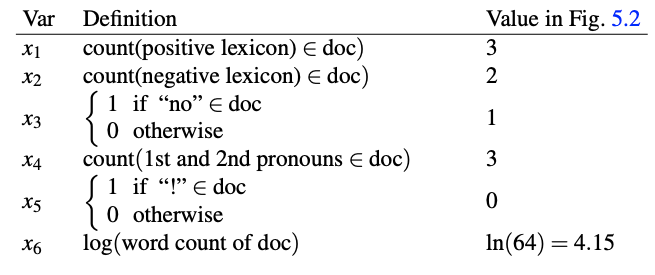

Please use the files with postive and negative words attached in the assignment: [positive_words.txt](data/poisitive-words.txt) and  [negative_words.txt](data/negative-words.txt)

In [663]:
### ENTER CODE HERE ###

def load_word_list(file_path):
    """Reads words from a file and returns a set."""
    with open(file_path, "r", encoding="utf-8") as f:
        return set(word.strip() for word in f.readlines())

positive_words = load_word_list("../data/positive-words.txt")
negative_words = load_word_list("../data/negative-words.txt")


def count_lexicon_words(text_tokens, lexicon):
    """Counts how many words from the lexicon appear in the text."""
    count = 0
    for token in text_tokens:
        if token in lexicon:
            count += 1
    return count


def make_test_feature(text: spacy.tokens.doc.Doc):
    return "happy" in [t.lemma_ for t in text]


def extract_features(text: spacy.tokens.doc.Doc):
    features = []
    # TODO: Replace this with your own feature extraction functions.
    features.append(make_test_feature(text))
    # TODO: add more features to the feature vector
    # Convert text to lowercase lemmas
    text_tokens = [token.lemma_.lower() for token in text]
    
    # Feature 1: Count of positive words
    features.append(count_lexicon_words(text_tokens, positive_words))

    # Feature 2: Count of negative words
    features.append(count_lexicon_words(text_tokens, negative_words))

    # Feature 3: Presence of "no" (binary: 1 if present, else 0)
    features.append(1 if "no" in text_tokens else 0)

    # Feature 4: Count of 1st & 2nd person pronouns
    pronouns = {"i", "me", "my", "mine", "we", "us", "our", "ours", "you", "your", "yours"}
    pronoun_count = sum(1 for token in text_tokens if token in pronouns)
    features.append(pronoun_count)

    # Feature 5: Presence of "!" (binary: 1 if present, else 0)
    features.append(1 if "!" in [token.text for token in text] else 0)

    # Feature 6: Total word count
    features.append(len(text_tokens))
    
    return features

In [664]:
# Test case: Example sentence
test_text = "This is an amazing place! I love it, but no service was available."
test_doc = nlp(test_text)  # Process text with spaCy

# Extract features
features = extract_features(test_doc)

# Define labels for better readability
feature_labels = [
    "Test feature (contains 'happy')",
    "Positive words count",
    "Negative words count",
    "Presence of 'no' (binary)",
    "First/Second-person pronouns count",
    "Presence of '!' (binary)",
    "Total word count"
]

# Print test sentence
print(f"Test Sentence: \"{test_text}\"")

# Print extracted features with explanations
print("\nExtracted Features:", features)
print("\nWhere:")
for label, value in zip(feature_labels, features):
    print(f"    {value} → ({label})")


Test Sentence: "This is an amazing place! I love it, but no service was available."

Extracted Features: [False, 3, 0, 1, 1, 1, 16]

Where:
    False → (Test feature (contains 'happy'))
    3 → (Positive words count)
    0 → (Negative words count)
    1 → (Presence of 'no' (binary))
    1 → (First/Second-person pronouns count)
    1 → (Presence of '!' (binary))
    16 → (Total word count)


In [665]:
### DO NOT EDIT ###

def featurize_data(texts, labels):
    features = [
        extract_features(doc) for doc in nlp.pipe(texts)
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

##### 2.2.1.4: Feature Scaling (5 Points)

In this task we will use the data normalization technique to ensure the scales of the feature are consistent.
After featurizing the dataset, we need to call the following function before passing it to the classifier

* Normalization Formula

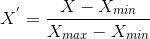

In [666]:
### ENTER CODE HERE ###

def normalize(features: torch.Tensor) -> torch.Tensor:
    """
    return the features transformed by the above formula of normalization
    """
    min_vals, _ = torch.min(features, dim=0, keepdim=True)  # X_min
    max_vals, _ = torch.max(features, dim=0, keepdim=True)  # X_max

    # Avoid division by zero (if max == min, set denominator to 1)
    denom = max_vals - min_vals
    denom[denom == 0] = 1  # Prevent division by zero errors

    # Apply min-max normalization formula
    normalized_features = (features - min_vals) / denom

    return normalized_features

#### Task 2.2.2 Training a Logistic Regression Classifier (Total: 30 Points)

In this section, you will implement the components needed to train the binary classifier using logistic regression

* Here we define our pytorch logistic regression classifier (DO NOT EDIT THIS)

In [667]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        # We force output to be one, since we are doing binary logistic regression
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)
        # Initialize weights. Note that this is not strictly necessary,
        # but you should test different initializations per lecture
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        # We predict a number by multipling by the coefficients
        # and then take the sigmoid to turn the score as logits
        return torch.sigmoid(self.coefficients(features))

##### 2.2.2.1 : Initialize the weights. (5 Points)

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, we need to try different initialization methods and compare the accuracy we achieve for the development set. In this task, implement the function that initializes the parameters to ...

In [668]:
### ENTER CODE HERE ###

def initialize_weights(coefficients):
    """
    TODO: Replace the line `raise NotImplementedError` with your code.
    Initialize the weights of the coefficients by assigning the parameter
    coefficients.weights.data = ...
    """
    torch.nn.init.normal_(coefficients.weight, mean=0.0, std=0.01)
    torch.nn.init.zeros_(coefficients.bias)

Let's build a training function similar to the linear regressor from the tutorial

##### 2.2.2.2: Logistic Loss Function (10 Points)

In [669]:
### ENTER CODE HERE ###
def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    """
    TODO: Implement the logistic loss function between a prediction and label.
    """
    epsilon = 1e-10
    prediction = torch.clamp(prediction, epsilon, 1 - epsilon)  # Ensure values are within (0,1)

    # Compute BCE loss manually using the formula
    loss = - (label * torch.log(prediction) + (1 - label) * torch.log(1 - prediction))

    # Return the mean loss over all samples
    return loss.mean()

##### 2.2.2.3: Create an SGD optimizer (0 Points)

In the lecture, we only briefly mentioned the optimizer SGD. Here we offered another example for you to create your simple optimizer by implementing the gradient, learning rate, and weight updates. In real prictice, you could simply use existing optimier code in the assignments. 

Consider the function you hope to learn is a quadrtic function 

In [670]:
### DO NOT EDIT ###
import numpy as np

def quadratic_loss(x1, x2):
    """
    Assuming we have a loss function, which is a quadratic function of two weight paramters.
    Obviously, this is not a logistic loss function, but we will use it for testing purposes.
    The mimumum of this function is 0 at (1, 1)
    :param x1: first coordinate in weight vector [x1, x2]
    :param x2: second coordinate in weight vector [x1, x2]
    :return:
    """
    return (x1 - 1) ** 2 + 8 * (x2 - 1) ** 2

In [671]:
### ENTER CODE HERE ###
def quadratic_loss_grad(x1, x2):
    """
    Should return a numpy array containing the gradient of the quadratic function defined above evaluated at the point
    :param x1: first coordinate in weight vector [x1, x2]
    :param x2: second coordinate in weight vector [x1, x2]
    :return: a one-dimensional numpy array containing two elements representing the gradient
    """
    grad_x1 = 2 * (x1 - 1)
    grad_x2 = 16 * (x2 - 1)
    
    return np.array([grad_x1, grad_x2])

In [672]:
### DO NOT EDIT ###
import numpy as np
import matplotlib.pyplot as plt

def sgd_test_quadratic(lr: float, epochs: int):
    xlist = np.linspace(-3.0, 3.0, 100)
    ylist = np.linspace(-3.0, 3.0, 100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = quadratic_loss(X, Y)
    plt.figure()

    # Track the points visited here
    points_history = []
    curr_point = np.array([0., 0.])
    for iter in range(0, epochs):
        grad = quadratic_loss_grad(curr_point[0], curr_point[1])
        if len(grad) != 2:
            raise Exception("Gradient must be a two-dimensional array (vector containing [df/dx1, df/dx2])")
        next_point = curr_point - lr * grad
        points_history.append(curr_point)
        print("Point after epoch %i: %s" % (iter, repr(next_point)))
        curr_point = next_point
    points_history.append(curr_point)
    cp = plt.contourf(X, Y, Z)
    plt.colorbar(cp)
    plt.plot([p[0] for p in points_history], [p[1] for p in points_history], color='k', linestyle='-', linewidth=1, marker=".")
    plt.title('SGD on quadratic')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [673]:
sgd_test_quadratic(0.1, 20)

Point after epoch 0: array([0.2, 1.6])
Point after epoch 1: array([0.36, 0.64])
Point after epoch 2: array([0.488, 1.216])
Point after epoch 3: array([0.5904, 0.8704])
Point after epoch 4: array([0.67232, 1.07776])
Point after epoch 5: array([0.737856, 0.953344])
Point after epoch 6: array([0.7902848, 1.0279936])
Point after epoch 7: array([0.83222784, 0.98320384])
Point after epoch 8: array([0.86578227, 1.0100777 ])
Point after epoch 9: array([0.89262582, 0.99395338])
Point after epoch 10: array([0.91410065, 1.00362797])
Point after epoch 11: array([0.93128052, 0.99782322])
Point after epoch 12: array([0.94502442, 1.00130607])
Point after epoch 13: array([0.95601953, 0.99921636])
Point after epoch 14: array([0.96481563, 1.00047018])
Point after epoch 15: array([0.9718525 , 0.99971789])
Point after epoch 16: array([0.977482  , 1.00016927])
Point after epoch 17: array([0.9819856 , 0.99989844])
Point after epoch 18: array([0.98558848, 1.00006094])
Point after epoch 19: array([0.98847078,

In the above figure, you will see the point from the (0, 0, 9) moving to the minimum of the quardic loss is obtained at (1,1,0)
We have already provided the implementation of how to create the SGD optimizer. However, in real practise, our loss are much more complicated than this, especially for the neural networks. Recently large language models are trained with more 650B parameters. In late semester, we also learned that sometimes we need not to train all the parameters during the so-called finetuning stage.
We may try different optimizing algorithms more than SGD, such as Adam, AdamW or more. https://pytorch.org/docs/stable/optim.html
In this example, you should not change this code, so we use SGD. For the Task 2.3, when you train you own classifier from scratch. You could try any of optimizer. 

In [674]:
def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    See here for algorithms you can import: https://pytorch.org/docs/stable/optim.html
    """
    return torch.optim.SGD(model.parameters(), learning_rate)

##### 2.2.2.4: Converting Logits into Predictions (5 Points)

In [675]:
### ENTER CODE HERE ###

def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)
        probabilities = torch.sigmoid(logits)  
        predictions = (probabilities >= 0.5).float()
        return predictions

##### 2.2.2.5: Training Function (DO NOT EDIT THIS)

In [676]:
### DO NOT EDIT ###

from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model, dev_features), dev_labels)
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

##### 2.2.2.6: Train the classifier (10 Points)

Run the following cell to train a logistic regressor on your hand-engineered features.

In [677]:
### DO NOT EDIT ###

num_epochs = 100

train_features, train_labels_tensor = featurize_data(train_texts, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.01)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0, loss: 0.6931964099407196
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1, loss: 0.6922261238098144
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2, loss: 0.6912603914737702
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3, loss: 0.6902992725372314
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4, loss: 0.689342588186264
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5, loss: 0.688390451669693
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6, loss: 0.6874427378177643
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7, loss: 0.6864994287490844
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8, loss: 0.6855604588985443
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9, loss: 0.6846258819103241
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10, loss: 0.6836955904960632
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11, loss: 0.6827695608139038
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12, loss: 0.6818477869033813
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13, loss: 0.68093022108078
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14, loss: 0.680016815662384
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15, loss: 0.6791075527667999
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16, loss: 0.6782024681568146
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17, loss: 0.6773014485836029
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18, loss: 0.6764044523239136
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19, loss: 0.6755115330219269
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20, loss: 0.6746225893497467
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21, loss: 0.6737376511096954
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22, loss: 0.6728566348552704
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23, loss: 0.671979558467865
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24, loss: 0.6711063861846924
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25, loss: 0.6702370762825012
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26, loss: 0.6693716168403625
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27, loss: 0.668509978055954
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28, loss: 0.6676521599292755
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29, loss: 0.66679807305336
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30, loss: 0.6659477591514588
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 31, loss: 0.6651011824607849
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 32, loss: 0.6642582774162292
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 33, loss: 0.6634190499782562
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 34, loss: 0.6625835061073303
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 35, loss: 0.6617515861988068
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 36, loss: 0.6609232723712921
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 37, loss: 0.660098522901535
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 38, loss: 0.6592773556709289
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 39, loss: 0.6584597110748291
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 40, loss: 0.657645583152771
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 41, loss: 0.6568349480628968
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 42, loss: 0.6560278058052063
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 43, loss: 0.6552241206169128
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 44, loss: 0.654423838853836
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 45, loss: 0.6536270022392273
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 46, loss: 0.6528335332870483
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 47, loss: 0.6520434260368347
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 48, loss: 0.6512566864490509
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 49, loss: 0.6504732966423035
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 50, loss: 0.6496931731700897
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 51, loss: 0.648916345834732
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 52, loss: 0.648142808675766
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 53, loss: 0.6473724842071533
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 54, loss: 0.6466054141521453
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 55, loss: 0.6458415687084198
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 56, loss: 0.6450808882713318
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 57, loss: 0.6443233609199523
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 58, loss: 0.6435690104961396
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 59, loss: 0.6428177654743195
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 60, loss: 0.6420696794986724
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 61, loss: 0.6413246870040894
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 62, loss: 0.6405827462673187
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 63, loss: 0.639843875169754
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 64, loss: 0.6391080379486084
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 65, loss: 0.6383752048015594
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 66, loss: 0.6376454174518585
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 67, loss: 0.6369185864925384
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 68, loss: 0.6361947596073151
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 69, loss: 0.6354738354682923
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 70, loss: 0.6347558736801148
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 71, loss: 0.6340408325195312
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 72, loss: 0.633328664302826
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 73, loss: 0.6326193988323212
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 74, loss: 0.6319129884243011
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 75, loss: 0.6312094449996948
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 76, loss: 0.6305087208747864
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 77, loss: 0.6298108279705048
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 78, loss: 0.6291157245635987
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 79, loss: 0.6284233927726746
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 80, loss: 0.627733850479126
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 81, loss: 0.6270470201969147
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 82, loss: 0.62636296749115
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 83, loss: 0.6256815791130066
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 84, loss: 0.6250029325485229
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 85, loss: 0.6243269324302674
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 86, loss: 0.6236536502838135
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 87, loss: 0.6229830205440521
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 88, loss: 0.6223149955272674
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 89, loss: 0.6216496407985688
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 90, loss: 0.6209868490695953
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 91, loss: 0.6203266859054566
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 92, loss: 0.6196690738201142
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 93, loss: 0.619014036655426
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 94, loss: 0.6183615803718567
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 95, loss: 0.6177116215229035
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 96, loss: 0.6170641839504242
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 97, loss: 0.6164192855358124
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 98, loss: 0.6157768607139588
Dev F1 tensor([0.6667])


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 99, loss: 0.6151368975639343
Dev F1 tensor([0.6667])


Get the predictions on the Test Set using the Trained model and print the F1 score.

In [678]:
### DO NOT EDIT ###

### DEV SET RESULTS

dev_features, dev_labels = featurize_data(dev_texts, dev_labels)
print('Dev Set Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, dev_features), dev_labels))
print('F1-score', f1_score(predict(trained_model, dev_features), dev_labels))

Dev Set Logistic Regression Results:
Accuracy: tensor([0.5000])
F1-score tensor([0.6667])


In [679]:
### DO NOT EDIT ###
### TEST SET RESULTS

test_features, test_labels = featurize_data(test_texts, test_labels)
print('Test Set Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels))

Test Set Logistic Regression Results:
Accuracy: tensor([0.5000])
F1-score tensor([0.6667])


### Task 2.3: Multinomial Logistic Regression with Deep Averaging Network (Total: 40 points = 20 programming and 20 written reports)

Beyond manually crafted features, let us move on the pretrained word embeddings. How well our word embedding based classifcation performed on sentiment classification. According to the previous tutorial on using pytorch to train a logistic regression model for binary classification. Now you will be given a new multiclass classification task with a new sentiment dataset (SST-5), which has 5 labels: very positive, positive, neutral, negative, very negative . Please implement a new pytorch model from scratch for Multinomial Logistic Regression. This code is in the seperate python file news_classifier.py.



Ideally, this task 2.3 should be decomposed in two subtasks:
1. Task 2.3.1 Exploratory Data Analysis to understand the new dataset (Please show some distribution analysis in the notebook by creating new cells below)
2. Task 2.3.2 Using the task 2.2 as an pytorch example, please build your own Multiclass classifier on this new dataset with the following main changes
* Multiclass and New Dataset
* Use Word Embedding and Deep Average Network.

Your code should report the Accuracy,  F1 score for each label, and macro F1 for a combined score. (You don't need to reimplement all your metrics in Task 2.2. Please directly use classification_report to report the performance on devset and test set. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

Training this may take around 20 minutes according your implementation. Hence we will not train your model from scratch to obtain a results. Please write a report to demonstrate your training and results. 

Hence, your submission for Task 2.3: 
1. A single pdf with both your exploration for the dataset, and your experiments for the semsentiment classification
2. The whole folder (remove the data folder, and the cache folders, such as __pycache__,  .env .conda)

Hints: 
1. To start, simply copy the code snippets from Task 2.1 and 2.2 into your own code hotel_sentiment_classifier.py. Make it runnable, and replicate the results you have done in the above tutorial.
2. PAY ATTENTION!!! You have to adapt those code to support your "multiclass classifer", including dataset reading, using softmax function, cross-entropy loss, and the model, and many details not listed here. Please explore that by yourself.

#### Task 2.3.1 Exploratory Data Analysis on SST-5

In [680]:
# Load the dataset
from datasets import load_dataset

ds = load_dataset("SetFit/sst5")

Repo card metadata block was not found. Setting CardData to empty.


In [681]:
train_dataset = ds['train']
dev_dataset = ds['validation']
test_dataset = ds['test']
train_dataset[0]

{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films',
 'label': 4,
 'label_text': 'very positive'}

In [682]:
# The dataset is already split into train, dev, and test. So you don't need to split it again.
len(train_dataset), len(dev_dataset), len(test_dataset) 

(8544, 1101, 2210)

In [683]:
import pandas as pd
df_train = ds["train"].to_pandas()
print(df_train.head(5))


                                                text  label     label_text
0  a stirring , funny and finally transporting re...      4  very positive
1  apparently reassembled from the cutting-room f...      1       negative
2  they presume their audience wo n't sit still f...      1       negative
3  the entire movie is filled with deja vu moments .      2        neutral
4  this is a visually stunning rumination on love...      3       positive


In [684]:
import pandas as pd
df_train = ds["train"].to_pandas()
print(df_train.tail(5))


                                                   text  label     label_text
8539  take care is nicely performed by a quintet of ...      1       negative
8540  the script covers huge , heavy topics in a bla...      1       negative
8541  a seriously bad film with seriously warped log...      1       negative
8542   it 's not too racy and it 's not too offensive .      2        neutral
8543  a deliciously nonsensical comedy about a city ...      4  very positive


In [685]:
### ENTER CODE FOR EXPLORATORY HERE ###
# Check the structure of one example in the dataset
print(" Sample Data from Training Set:")
print(train_dataset[0])

# Check dataset sizes
print("\n Dataset Sizes:")
print(f"Train: {len(train_dataset)}, Dev: {len(dev_dataset)}, Test: {len(test_dataset)}")

# Check keys in dataset
print("\n Available Keys in Dataset:")
print(train_dataset.features)


 Sample Data from Training Set:
{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 4, 'label_text': 'very positive'}

 Dataset Sizes:
Train: 8544, Dev: 1101, Test: 2210

 Available Keys in Dataset:
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'label_text': Value(dtype='string', id=None)}



 Label Counts:
Train: Counter({3: 2322, 1: 2218, 2: 1624, 4: 1288, 0: 1092})
Dev: Counter({1: 289, 3: 279, 2: 229, 4: 165, 0: 139})
Test: Counter({1: 633, 3: 510, 4: 399, 2: 389, 0: 279})


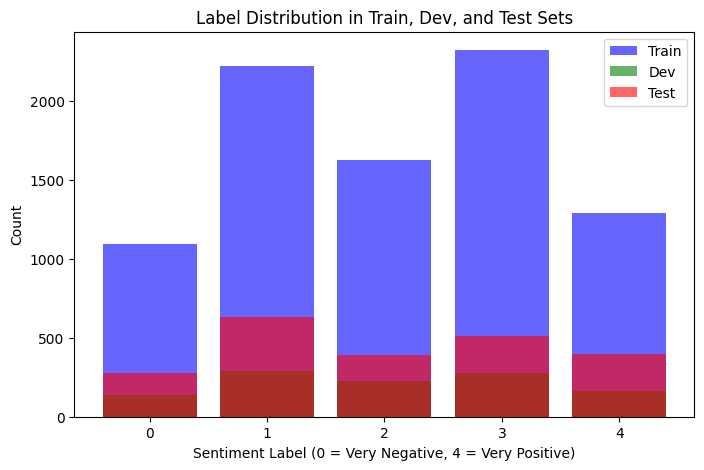

In [686]:
import matplotlib.pyplot as plt
from collections import Counter

# Count labels in each dataset
train_labels = [example['label'] for example in train_dataset]
dev_labels = [example['label'] for example in dev_dataset]
test_labels = [example['label'] for example in test_dataset]

train_label_counts = Counter(train_labels)
dev_label_counts = Counter(dev_labels)
test_label_counts = Counter(test_labels)

# Print label distributions
print("\n Label Counts:")
print("Train:", train_label_counts)
print("Dev:", dev_label_counts)
print("Test:", test_label_counts)

# Plot label distribution
plt.figure(figsize=(8, 5))
plt.bar(train_label_counts.keys(), train_label_counts.values(), color='blue', alpha=0.6, label="Train")
plt.bar(dev_label_counts.keys(), dev_label_counts.values(), color='green', alpha=0.6, label="Dev")
plt.bar(test_label_counts.keys(), test_label_counts.values(), color='red', alpha=0.6, label="Test")
plt.xlabel("Sentiment Label (0 = Very Negative, 4 = Very Positive)")
plt.ylabel("Count")
plt.xticks([0, 1, 2, 3, 4])
plt.legend()
plt.title("Label Distribution in Train, Dev, and Test Sets")
plt.show()


In [687]:
# Function to print example sentences from each sentiment class
def print_examples(dataset, num_examples=2):
    label_groups = {i: [] for i in range(5)}
    
    for example in dataset:
        label_groups[example['label']].append(example['text'])
    
    print("\n Example Sentences from Each Sentiment Class:\n")
    for label, texts in label_groups.items():
        print(f" Sentiment {label} ({len(texts)} samples):")
        for text in texts[:num_examples]:
            print(f"  ➡ {text}")
        print("-" * 50)

# Print examples from training dataset
print_examples(train_dataset)



 Example Sentences from Each Sentiment Class:

 Sentiment 0 (1092 samples):
  ➡ final verdict : you 've seen it all before .
  ➡ lacks the inspiration of the original and has a bloated plot that stretches the running time about 10 minutes past a child 's interest and an adult 's patience .
--------------------------------------------------
 Sentiment 1 (2218 samples):
  ➡ apparently reassembled from the cutting-room floor of any given daytime soap .
  ➡ they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
--------------------------------------------------
 Sentiment 2 (1624 samples):
  ➡ the entire movie is filled with deja vu moments .
  ➡ um , no. .
--------------------------------------------------
 Sentiment 3 (2322 samples):
  ➡ this is a visually stunning rumination on love , memory , history and the war betw

In [688]:
# Compute text lengths
train_lengths = [len(example['text'].split()) for example in train_dataset]

# Find min, max, average length
print("\n Text Length Statistics:")
print(f"Min Length: {min(train_lengths)} words")
print(f"Max Length: {max(train_lengths)} words")
print(f"Average Length: {sum(train_lengths) / len(train_lengths):.2f} words")

# Find short and long texts
short_texts = [example['text'] for example in train_dataset if len(example['text'].split()) < 5]
long_texts = [example['text'] for example in train_dataset if len(example['text'].split()) > 50]

print("\n Example of Very Short Texts:")
for text in short_texts[:3]: print(f"- {text}")

print("\n Example of Very Long Texts:")
for text in long_texts[:3]: print(f"- {text[:300]}...")  # Show only first 300 characters



 Text Length Statistics:
Min Length: 2 words
Max Length: 52 words
Average Length: 19.14 words

 Example of Very Short Texts:
- um , no. .
- too bad .
- a fun ride .

 Example of Very Long Texts:
- if you are curious to see the darker side of what 's going on with young tv actors -lrb- dawson leery did what ?!? -rrb- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie ....
- it may not be as cutting , as witty or as true as back in the glory days of weekend and two or three things i know about her , but who else engaged in filmmaking today is so cognizant of the cultural and moral issues involved in the process ?...
- it 's a bad sign when you 're rooting for the film to hurry up and get to its subjects ' deaths just so the documentary will be over , but it 's indicative of how uncompelling the movie is unless it happens to cover your particular area of interest ....


In [689]:
from collections import Counter
nlp = spacy.load("en_core_web_sm")
# Tokenize all text and count word frequencies
word_counts = Counter()
for example in train_dataset:
    tokens = [token.lemma_.lower() for token in nlp(example['text']) if token.is_alpha]
    word_counts.update(tokens)

# Most common words
most_common_words = word_counts.most_common(20)

# Least common words (rare words)
least_common_words = word_counts.most_common()[:-20:-1]

print("\n Most Common Words in Training Set:")
for word, count in most_common_words:
    print(f"{word}: {count}")

print("\n Least Common Words in Training Set:")
for word, count in least_common_words:
    print(f"{word}: {count}")



 Most Common Words in Training Set:
the: 7353
a: 5305
and: 4517
of: 4456
be: 4340
to: 3052
it: 2428
that: 1955
in: 1917
film: 1306
as: 1299
movie: 1176
but: 1172
with: 1139
have: 1093
for: 1037
this: 998
an: 974
its: 944
you: 860

 Least Common Words in Training Set:
racy: 1
wimmer: 1
warp: 1
surfacey: 1
quintet: 1
mcdormand: 1
intriguingly: 1
indicate: 1
overstuff: 1
analysis: 1
irreparable: 1
enjoys: 1
monument: 1
personable: 1
appealingly: 1
curler: 1
comeback: 1
marcus: 1
embellish: 1


### Task 2.3.2 Build Your MultiClass Sentiment Classifier With Word Embedding and Deep Neural Networks.

You are given two sources of uncased pretrained embeddings you can use: data/glove.6B.50d-subset.txt
and data/glove.6B.300d-subset.txt.
These are trained using GloVe (Pennington et al., 2014). We only used a subset of this for a runtime and memory optimization.
It also means that it will not cover all your words. Hence, you need to handle the embeddings for the unkown words. (Glove is not subword tokenization)

In [690]:
import torch
import torch.nn as nn

# FloatTensor containing pretrained weights
weight = torch.FloatTensor([[1, 2.3, 3], [4, 5.1, 6.3]])
# Create an embedding layer from the weights, make it non-trainable
embedding = nn.Embedding.from_pretrained(weight, freeze=True)
# Get embeddings for index 1
input = torch.LongTensor([1])
embedding(input)

tensor([[4.0000, 5.1000, 6.3000]])

In [691]:
def load_word_vectors(filepath: str = "../data/glove.6B.300d-subset.txt", example_sentence: str = None) -> torch.FloatTensor:
    """
    Load the word vectors from a file and return a torch.FloatTensor where each row is a word vector
    for a word, with the row index corresponding to the word index. A special [UNK] token is added at index 0
    to handle words that are not present in the embedding file.
    
    Args:
        filepath (str): Path to the word vector file. Defaults to "../data/glove.6B.50d-subset.txt".
        example_sentence (str, optional): An example sentence to test the lookup of words.
    
    Returns:
        torch.FloatTensor: each row is a word vector for a word.
    """
    import torch
    import re

    vectors = []
    word2idx = {}  # mapping for internal use

    # Reserve index 0 for [UNK] token (unknown words)
    word2idx["[UNK]"] = 0

    with open(filepath, "r", encoding="utf-8") as f:
        # Read first line to determine embedding dimension.
        first_line = f.readline().strip().split()
        if not first_line or len(first_line) < 2:
            raise ValueError("The embedding file is empty or formatted incorrectly.")
        embed_dim = len(first_line) - 1
        # Create [UNK] vector: a vector of zeros
        unk_vector = [0.0] * embed_dim
        vectors.append(unk_vector)  # [UNK] at index 0

        # Process the first line
        word = first_line[0]
        vector = [float(x) for x in first_line[1:]]
        word2idx[word] = len(vectors)
        vectors.append(vector)

        # Process remaining lines
        for line in f:
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                continue  # skip malformed lines
            word = parts[0]
            vector = [float(x) for x in parts[1:]]
            word2idx[word] = len(vectors)
            vectors.append(vector)

    embedding_tensor = torch.FloatTensor(vectors)
    
    # Clear, user-friendly printout
    print("==============================================")
    print("GloVe Embeddings Loaded")
    print("----------------------------------------------")
    print(f"Total words loaded (including special [UNK]): {embedding_tensor.size(0)}")
    print(f"Each word vector has {embedding_tensor.size(1)} numbers (dimensions).")
    print("==============================================\n")
    
    # If an example sentence is provided, process it
    if example_sentence is not None:
        tokens = re.findall(r"\w+", example_sentence.lower())
        unknown_tokens = [token for token in tokens if token not in word2idx]
        
        print("Example Sentence Provided:")
        print(f"  \"{example_sentence}\"")
        print("\nThe sentence was broken into these words (tokens):")
        print(f"  {tokens}")
        
        if unknown_tokens:
            print("\nThese words were NOT found in the GloVe vocabulary and will be treated as unknown ([UNK]):")
            print(f"  {unknown_tokens}")
        else:
            print("\nAll words in the sentence were found in the GloVe vocabulary!")
        print("==============================================\n")
    
    return embedding_tensor


In [692]:
embeddings = load_word_vectors(example_sentence="This sentence includes supercalifragilisticexpialidocious and unknownwordxyz.")


GloVe Embeddings Loaded
----------------------------------------------
Total words loaded (including special [UNK]): 14922
Each word vector has 300 numbers (dimensions).

Example Sentence Provided:
  "This sentence includes supercalifragilisticexpialidocious and unknownwordxyz."

The sentence was broken into these words (tokens):
  ['this', 'sentence', 'includes', 'supercalifragilisticexpialidocious', 'and', 'unknownwordxyz']

These words were NOT found in the GloVe vocabulary and will be treated as unknown ([UNK]):
  ['supercalifragilisticexpialidocious', 'unknownwordxyz']



In [693]:
# Call the function with a known example sentence
embeddings = load_word_vectors(example_sentence="the quick brown dog jumps over the lazy dog")


GloVe Embeddings Loaded
----------------------------------------------
Total words loaded (including special [UNK]): 14922
Each word vector has 300 numbers (dimensions).

Example Sentence Provided:
  "the quick brown dog jumps over the lazy dog"

The sentence was broken into these words (tokens):
  ['the', 'quick', 'brown', 'dog', 'jumps', 'over', 'the', 'lazy', 'dog']

All words in the sentence were found in the GloVe vocabulary!



In [694]:
   
   # This code loads the SST-5 sentiment dataset and GloVe embeddings, builds a deep neural network (Deep Average Network) 
   # for 5-class sentiment classification, trains the model, and then evaluates it by printing detailed 
   # training logs and a classification report.
    
%run ../src/sentiment_classifier.py

Repo card metadata block was not found. Setting CardData to empty.


Epoch 1/50 - Loss: 1.4538
Epoch 2/50 - Loss: 1.3251
Epoch 3/50 - Loss: 1.2891
Epoch 4/50 - Loss: 1.2692
Epoch 5/50 - Loss: 1.2473
Epoch 6/50 - Loss: 1.2340
Epoch 7/50 - Loss: 1.2181
Epoch 8/50 - Loss: 1.2018
Epoch 9/50 - Loss: 1.1880
Epoch 10/50 - Loss: 1.1740
Epoch 11/50 - Loss: 1.1574
Epoch 12/50 - Loss: 1.1414
Epoch 13/50 - Loss: 1.1289
Epoch 14/50 - Loss: 1.1149
Epoch 15/50 - Loss: 1.1005
Epoch 16/50 - Loss: 1.0875
Epoch 17/50 - Loss: 1.0707
Epoch 18/50 - Loss: 1.0586
Epoch 19/50 - Loss: 1.0422
Epoch 20/50 - Loss: 1.0288
Epoch 21/50 - Loss: 1.0191
Epoch 22/50 - Loss: 1.0025
Epoch 23/50 - Loss: 0.9880
Epoch 24/50 - Loss: 0.9739
Epoch 25/50 - Loss: 0.9610
Epoch 26/50 - Loss: 0.9458
Epoch 27/50 - Loss: 0.9328
Epoch 28/50 - Loss: 0.9186
Epoch 29/50 - Loss: 0.9069
Epoch 30/50 - Loss: 0.8943
Epoch 31/50 - Loss: 0.8774
Epoch 32/50 - Loss: 0.8648
Epoch 33/50 - Loss: 0.8517
Epoch 34/50 - Loss: 0.8394
Epoch 35/50 - Loss: 0.8287
Epoch 36/50 - Loss: 0.8117
Epoch 37/50 - Loss: 0.7971
Epoch 38/5

## Section 3: Sequence Labeling and Viterbi Algorithm (Total: 20 points)

For this assignment, we will implement the Viterbi Decoder using the Forward Algorithm of Hidden Markov Model as explained in class.

Then, we will create an HMM-based PoS Tagger for Hindi language using the annotated Tagset in nltk.indian

You need to first implement the missing code in hmm.py, then run the cells here to get the points.

In [695]:
from tqdm.autonotebook import tqdm
## if you have a tqdm error, you can install it by running `!pip install tqdm`
## also add sys.path.append("../src") to the top of the notebook, so that you can import hmm.py
sys.path.append("../src")

# This is so that you don't have to restart the kernel everytime you edit hmm.py

%load_ext autoreload
%autoreload 2
from hmm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1st-Order Hidden Markov Model Class:

The hidden markov model class would have the following attributes: 
    
    1. initial state log-probs vector (pi)
    2. state transition log-prob matrix (A)
    3. observation log-prob matrix (B)

The following methods:
    
    1. fit method to count the probabilitis of the training set
    2. path probability
    3. viterbi decoding algorithm

### Task 3.1: Testing the HMM (15 Points)

In [696]:
### DO NOT EDIT THIS, but you need fix the hmm.py ###

# 5 points for the fit test case
# 10 points for the decode test case

# run the funtion that tests the HMM with synthetic parameters!
run_tests()

Testing the fit function of the HMM
All Test Cases Passed!
Testing the decode function of the HMM
All Test Cases Passed!
Yay! You have a working HMM. Now try creating a pos-tagger using this class.


### Task 3.2: PoS Tagging on Hindi Tagset (5 Points)

For this assignment, we will use the Hindi Tagged Dataset available with nltk.indian

Helper methods to load the dataset is provided in hmm.py

Please go through the functions and explore the dataset

Report the Accuracy for the Dev and Test Sets. You should get something between 65-85%

In [697]:
words, tags, observation_dict, state_dict, all_observation_ids, all_state_ids = get_hindi_dataset()

# we need to add the id for unknown word (<unk>) in our observations vocab
UNK_TOKEN = '<unk>'

observation_dict[UNK_TOKEN] = len(observation_dict)
print("id of the <unk> token:", observation_dict[UNK_TOKEN])
print("No. of unique words in the corpus:", len(observation_dict))
print("No. of tags in the corpus", len(state_dict))

id of the <unk> token: 2186
No. of unique words in the corpus: 2187
No. of tags in the corpus 26


In [698]:
# Split the dataset into train, validation and development sets

import random
random.seed(42)
from sklearn.model_selection import train_test_split

data_indices = list(range(len(all_observation_ids)))

train_indices, dev_indices = train_test_split(data_indices, test_size=0.2, random_state=42)

dev_indices, test_indices = train_test_split(dev_indices, test_size=0.5, random_state=42)

print(len(train_indices), len(dev_indices), len(test_indices))


def get_state_obs(state_ids, obs_ids, indices):
    return [state_ids[i] for i in indices], [obs_ids[i] for i in indices]


train_state_ids, train_observation_ids = get_state_obs(all_state_ids, all_observation_ids, train_indices)
dev_state_ids, dev_observation_ids = get_state_obs(all_state_ids, all_observation_ids, dev_indices)
test_state_ids, test_observation_ids = get_state_obs(all_state_ids, all_observation_ids, test_indices)

432 54 54


In [699]:
def add_unk_id(observation_ids, unk_id, ratio=0.05):
    """
    make 1% of observations unknown
    """
    for obs in observation_ids:
        for i in range(len(obs)):
            if random.random() < ratio:
                obs[i] = unk_id

add_unk_id(train_observation_ids, observation_dict[UNK_TOKEN])
add_unk_id(dev_observation_ids, observation_dict[UNK_TOKEN])
add_unk_id(test_observation_ids, observation_dict[UNK_TOKEN])

In [700]:
pos_tagger = HMM(len(state_dict), len(observation_dict))
pos_tagger.fit(train_state_ids, train_observation_ids)

In [701]:
assert np.round(np.exp(pos_tagger.pi).sum()) == 1
assert np.round(np.exp(pos_tagger.A).sum()) == len(state_dict)
assert np.round(np.exp(pos_tagger.B).sum()) == len(state_dict)

print('All Test Cases Passed!')

All Test Cases Passed!


In [702]:
def accuracy(my_pos_tagger, observation_ids, true_labels):
    tag_predictions = my_pos_tagger.decode(observation_ids)
    tag_predictions = np.array([t for ts in tag_predictions for t in ts])
    true_labels_flat = np.array([t for ts in true_labels for t in ts])
    acc = np.sum(tag_predictions == true_labels_flat)/len(tag_predictions)
    return acc

Performance on dev and test on set (5')
Generally, If your Task 3.1 is correct, you don't need to edit anything to get this points. Just run through the code. 

In [703]:
print('dev accuracy:', accuracy(pos_tagger, dev_observation_ids, dev_state_ids))

dev accuracy: 0.8127659574468085


In [704]:
print('test accuracy:', accuracy(pos_tagger, test_observation_ids, test_state_ids))

test accuracy: 0.7987012987012987
